<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Wavelet_HOBO_GPR_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Installing extra packages on the current session
I use "george packages for the Gaussian Process analysis
Please visit here for further details: https://george.readthedocs.io/en/latest/user/kernels/


In [1]:
!pip install george


# Importing packages


In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [3]:
stationInfo = {
    10906989:{"timeZone": "US/Hawaii", "name": "ALOUN_HELEMANO", "GPS": "21 32 8.9 N 158 02 05.0 W"},  
    20173022:{"timeZone": "US/Hawaii", "name": "HIRAKO", "GPS": "20 00 14.6 N 155 41 29.3 W"}, 
    20009161:{"timeZone": "US/Hawaii", "name": "KULA_AG_PARK", "GPS": "20 47 43.2 N 156 21 35.6 W"}, 
    20121046:{"timeZone": "Pacific/Guam", "name": "MALOJLOJ MEDA", "GPS": "13 20 21.0 N 144 45 49.0 E"},
    20006321:{"timeZone": "US/Hawaii", "name": "MAO", "GPS": "21 27 4.9 N 158 09 25.8 W"},
    20173020:{"timeZone": "US/Hawaii", "name": "PIONEER CORN", "GPS": "21 33 41.5 N 158 07 40.3 W"},
    20173019:{"timeZone": "US/Hawaii", "name": "SEIZEN", "GPS": "20 01 26.2 N 155 39 00.5 W"},
    20824841:{"timeZone": "Pacific/Guam", "name": "WATSON", "GPS": ""},
    20824842:{"timeZone": "Pacific/Guam", "name": "WUSSTIG", "GPS": ""},
    20121045:{"timeZone": "Pacific/Guam", "name": "YIGO", "GPS": "13 33 54.3 N 144 52 38.4 E"},   #            
    20121047:{"timeZone": "Pacific/Samoa", "name": "MALAEIMI ", "GPS": ""},
    20121048:{"timeZone": "Pacific/Samoa", "name": "TAFETA", "GPS": ""},
    20173018:{"timeZone": "US/Hawaii", "name": "TEXEIRA", "GPS": ""},
    }



serial = 10906989
station = stationInfo[serial]["name"]
station

'ALOUN_HELEMANO'

In [4]:
data = pd.read_excel('/content/drive/MyDrive/HOBO_CAMPBELL_ET0_Rain.xlsx', sheet_name=station)

data.columns

Index(['Unnamed: 0', 'Date(US/Hawaii)', 'ETo_PM(inch/day)',
       'ETo_CIMIS(inch/day)', 'Rain(inch)', 'Tc', 'Tmin', 'Tmax', 'VPD', 'Rn',
       'ETo_PM (raw)', 'ETo_CIMIS (raw)', 'Rain (raw)'],
      dtype='object')

In [5]:
data.head()

,Unnamed: 0,Date(US/Hawaii),ETo_PM(inch/day),ETo_CIMIS(inch/day),Rain(inch),Tc,Tmin,Tmax,VPD,Rn,ETo_PM (raw),ETo_CIMIS (raw),Rain (raw)
0,0,2016-03-25,NaN,NaN,NaN,24.049190,23.544444,25.305556,0.913321,-0.175800,NaN,NaN,NaN
1,1,2016-03-26,NaN,NaN,NaN,23.472222,23.472222,23.509102,0.832428,-0.203134,NaN,NaN,NaN
2,2,2016-03-27,NaN,NaN,NaN,NaN,23.264815,23.788140,0.836598,-0.210989,NaN,NaN,NaN
3,3,2016-03-28,NaN,NaN,NaN,NaN,23.057407,24.067179,0.840767,-0.218843,NaN,NaN,NaN
4,4,2016-03-29,NaN,NaN,NaN,NaN,22.850000,24.346217,0.844936,-0.226698,NaN,NaN,NaN


In [6]:
data = data[['Date(US/Hawaii)', 'ETo_CIMIS (raw)', 'Rain(inch)', 'Tmin', 'Tmax', 'Tc', 'Rn', 'VPD']]

In [7]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("Date", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0, limit=3)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
# myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
# z_scaler = StandardScaler()
# z_data = z_scaler.fit_transform(myData)
# pca_data = PCA().fit_transform(z_data);
# pca_trafo = PCA().fit(z_data);
# data["P1"] = pca_data[:,0]
# data["P2"] = pca_data[:,1]
# data["P3"] = pca_data[:,3]

# displaying the first couple rows of the data table
data.tail(10)

,ETo_CIMIS,Rain,Tmin,Tmax,Tc,Rn,VPD
Date,,,,,,,
2020-11-21,0.076100,0.0,21.555556,25.500000,23.097222,0.123525,0.454270
2020-11-22,0.089718,0.0,21.511111,25.038889,22.740278,0.163113,0.452129
2020-11-23,0.101128,0.0,21.105556,25.838889,22.765046,0.181547,0.478613
2020-11-24,0.079844,0.0,20.316667,25.233333,22.196991,0.135294,0.319859
2020-11-25,0.036264,0.0,21.200000,24.872222,22.637037,0.008537,0.367656
2020-11-26,0.081620,0.0,19.461111,26.305556,21.979398,0.159426,0.427247
2020-11-27,0.067013,0.0,19.461111,25.016667,21.161111,0.114299,0.382137
2020-11-28,0.113043,0.0,18.388889,24.772222,21.088426,0.260906,0.493722
2020-11-29,0.103777,0.0,17.750000,24.411111,20.493287,0.248111,0.289457


In [8]:
import pywt

n_take = len(data)
n_level = 2
waveletname = 'db4'
SharpData = data['Rain'].values

data3 = pywt.downcoef('a', SharpData, waveletname, level=n_level)
data["Wa3"] = pywt.upcoef('a', data3, waveletname, level=n_level, take=n_take)

for i in range(n_level): 
  res = pywt.downcoef('d', SharpData, waveletname, level=i+1)
  data['Wd'+str(i+1)] = pywt.upcoef('d', res, waveletname, level=i+1, take=n_take)

data.head()

,ETo_CIMIS,Rain,Tmin,Tmax,Tc,Rn,VPD,Wa3,Wd1,Wd2
Date,,,,,,,,,,
2016-03-25,NaN,NaN,23.544444,25.305556,24.049190,-0.175800,0.913321,NaN,NaN,NaN
2016-03-26,NaN,NaN,23.472222,23.509102,23.472222,-0.203134,0.832428,NaN,NaN,NaN
2016-03-27,NaN,NaN,23.264815,23.788140,23.456410,-0.210989,0.836598,NaN,NaN,NaN
2016-03-28,NaN,NaN,23.057407,24.067179,23.440598,-0.218843,0.840767,NaN,NaN,NaN
2016-03-29,NaN,NaN,22.850000,24.346217,23.424786,-0.226698,0.844936,NaN,NaN,NaN


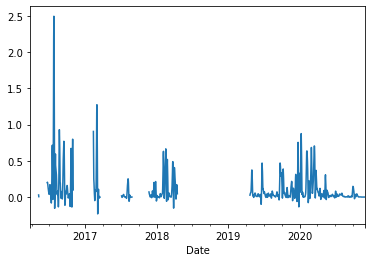

In [9]:
data["Wa3"].plot()

# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

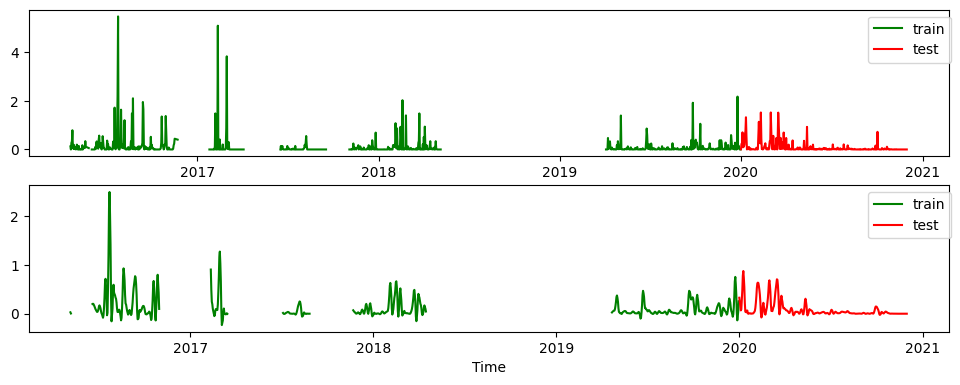

In [10]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

# training: 2010-2017
subData = data.loc[:"2019-12-31"]
N = len(subData)
x = subData.index
y = subData["Rain"]
z = subData["Wa3"]
v = subData["Wd2"]
w = subData["Wd1"]
u = w*0#subData["Wd3"]
tm = subData["ETo_CIMIS"]
tx = subData["ETo_CIMIS"]

# testing: 2013 onward
subData_test = data.loc["2020":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["Rain"]
z_test = subData_test["Wa3"]
v_test = subData_test["Wd2"]
w_test = subData_test["Wd1"]
u_test = w_test*0#subData_test["Wd3"]
tm_test = subData_test["ETo_CIMIS"]
tx_test = subData_test["ETo_CIMIS"]

# top plot 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, y, color='green', label="train")
ax.plot(x_test, y_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))


ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, z, color='green', label="train")
ax.plot(x_test, z_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))


ax.set_xlabel("Time")

In [11]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

def funcMAX(func, X, y, addParam = 0, maxiter=500, method='L-BFGS-B', verbose=False):
  
  '''
  A function to find the optimum parameters of the input funtion "func",
  where yp = func(X) and RMSE(y-yp) is minimzed

  output: "results" is the object that contains everything about the fit
  result.x holds the optimized parameters
  '''

  t1 =  datetime.now()  # t1 and t2 are used for timing this process
  ###########################################
  n = X.shape[1]
  # Maximum Likelihood
  Param_init = np.random.rand(n+addParam)
  result = minimize(func(X, y), Param_init, 
                method=method, options={"maxiter":maxiter})
  print("--------------------")
  if verbose:
    print(result)
  ###########################################
  if not verbose: 
    print("Fit Success: ", result.success)
  t2 =  datetime.now()
  print("Execution time: ", t2-t1)
  print("--------------------")

  return result

In [12]:
def dataPrepare2(y, z, v, w, u, n = 3, d = 1):
  '''
  Generating discrete data points out of the given series

  y: main signal, e.g. ET0
  z, v, w: auxiliary signals (set these to zero (e.g z=y*0) if not interested)
  n: the number of previous data points that are used for forcasting
  d: the number of days ahead for forecasting

  output: feature matrix XS, and target values ys
  '''

  N = len(y)
  dd = d - 1

  XS = np.zeros((N-n-dd, 4*n))
  ys = np.zeros(N-n-dd)

  p = 0 

  for i in range(0, N-n-dd):
    if not np.isnan(y[i:i+n]).any() and not np.isnan(y[i+n+dd]) and not np.isnan(z[i:i+n]).any() and not np.isnan(v[i:i+n]).any() and not np.isnan(w[i:i+n]).any():

      XS[p,:n]      = z[i:i+n]     
      XS[p,n:2*n]   = v[i:i+n]
      XS[p,2*n:3*n] = w[i:i+n]   
      XS[p,3*n:4*n] = u[i:i+n] 

      ys[p] = y[i+n+dd]
      p+=1

  return XS[:p,:], ys[:p]

# Defning the Gaussain Process using George package

Defning the *kernel*:

$k_{ij} = k(X_i, X_j) = \sigma^2 exp(-r^2)$,
where $r$ is the euclidean distance between $X_i$ and $X_j$.

$X$ is the parameter vector after normalization: $X=(x_1, x_2, ....)$. 
Let's assume, we use $ET0$ and $R_n$ as features. Then for each point in the feature space: $X= (ET0/L_1, R_n/L_2)$, where $L$ is the normalization factor. Vector $L$ and $\sigma$ are the free parameters of the kernel we are interested to find.To make use of the previous data points in the series, we can extend the number of features, i.e. $X= (ET0^{(1)}/L_1, R^{(1)}_n/L_2, ET0^{(2)}/L_3, R^{(2)}_n/L_4, ...)$. $ET0^{(1)}$ is the previous data point in the series, $ET0^{(2)}$ is the second previous data point etc. $X$ can hold as many as data point as we want. It can include a mixture of different parameters, other series, and basically anything that we think our problem depends on.
In the following function, $L$, $\sigma$, and $y_{err}$ are all given in the same array called $\theta$. $y_{err}$ represents the uncertainty of the target values (the present value of $ET0$) and is taken as a free parameter that basically prevents over-training.

In [13]:
from sklearn.model_selection import train_test_split

def GPR(X, y, lnlikelihood=True):
  '''
  The output of this function is another function, either the lnlikelihood, or 
  the gp (the gaussian process regressor that is dfined by giving theta)
  '''
  n = X.shape[1]
    
  def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          return -gp.lnlikelihood(y)
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
  return step

# Preparing the feature matrix, X, and the target vector, y
for the given training and cross_validation sets.

In the following example for mDelay=3, 3*4 features would be generated. 3-lags, four parameters each. So $X$ is 12-dimensional

In [14]:
# y: ET0 
# z: P1 (the first principal component)
# v: T (temperature)
# w: VPD

mDelay = 10
nAhead = 1

XS2, ys2 = dataPrepare2(y, z, v, w, u, n=mDelay, d=nAhead)
XS_test2, ys_test2 = dataPrepare2(y_test, z_test, v_test, w_test, u_test, n=mDelay, d=nAhead)

n_components = 4*mDelay

In [15]:
XS2.shape, ys2.shape

((576, 40), (576,))

In [16]:
XS2

array([[ 0.19839068,  0.20454924,  0.19730405, ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.20454924,  0.19730405,  0.17483341, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.19730405,  0.17483341,  0.15040261, ...,  0.        ,
         0.        , -0.        ],
       ...,
       [-0.0621561 , -0.01407573,  0.13226439, ..., -0.        ,
         0.        , -0.        ],
       [-0.01407573,  0.13226439,  0.34813009, ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.13226439,  0.34813009,  0.66043574, ..., -0.        ,
         0.        ,  0.        ]])

In [17]:
XS2.min(), XS2.max()

(-2.303651698908535, 2.496088755376591)

In [18]:
XS_test2.min(), XS_test2.max()

(-0.584564671636048, 0.8758144666507505)

In [19]:
XS_test2.shape, ys_test2.shape

((325, 40), (325,))

# Optional dimension reduction

Since the number of dimensions could be large, we can project all paraeters to a principal compnent space with lower dimensions. 

For instance, running the following cell, for n_components = 5, only 5 strongest components are utilized. Another advantage is that these 5 components are independent and not correlated. If the number of features is larges, using too small number components implies information leakage. 

# Finding the optimum parameters of the GP kernel

Here, we basically find the optimum parameters that maximize the likelihood of the defined GP. 

We can find the best parameters through the execution of an MCMC to make sure that we are not capturing the local extremums. 

# PSO with PySwarm
Optimizing the GPR hyperparameters using the Particle Swarm Optimizer

https://pyswarms.readthedocs.io/en/latest/index.html

In [20]:
!pip install pyswarms

In [21]:
# Import modules
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [22]:
XS2.shape, ys2.shape

((576, 40), (576,))

In [23]:
XS2.min(), XS2.max()

(-2.303651698908535, 2.496088755376591)

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
kf.get_n_splits(XS2)

def Xi2_swarm(x):
  
  nParticle = x.shape[0]
  out = np.zeros(nParticle)

  for train_index, cross_index in kf.split(XS2):
    
      X_train, X_cross = XS2[train_index], XS2[cross_index]
      y_train, y_cross = ys2[train_index], ys2[cross_index]

      n = X_cross.shape[1]
      m = X_cross.shape[0]

      for n_iter in range(nParticle):
          
          theta = x[n_iter,:]

          L = np.exp(theta[:n])

          gp = GPR(X_train, y_train, lnlikelihood=False)(theta)
          gp_yp_cross, gp_yp_cross_std = gp.predict(y_train, X_cross/np.vstack([L]*m), return_var=True)

          out[n_iter] += np.sum((y_cross - gp_yp_cross)**2)

  return out


In [25]:

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = GlobalBestPSO(n_particles=20, dimensions=n_components+2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(Xi2_swarm, iters=20)

2020-12-02 08:15:23,620 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=8.12
2020-12-02 08:16:04,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.12183219629903, best pos: [ 1.74961803  3.22672879  5.5190852   2.20459763  3.27720381  3.15143807
  4.5454777   1.61205613  6.10057817  2.13560032  2.13726723  1.45331236
  2.97469215  3.04634957  2.3819914   2.40438125  4.48689109  5.13142868
  5.27813161  1.29571659  1.92213246  1.49959857  2.30476411  2.45670427
  4.40123843  2.05065982  1.92897578  1.64002691  0.7373496   1.02675515
  2.45474938  0.95485123  2.13698984  1.07842512  4.28062677  6.16310422
  2.68708775  1.2744781   2.00036796  3.81780565  4.48898068 -0.71660357]


In [26]:
pos

array([ 1.74961803,  3.22672879,  5.5190852 ,  2.20459763,  3.27720381,
        3.15143807,  4.5454777 ,  1.61205613,  6.10057817,  2.13560032,
        2.13726723,  1.45331236,  2.97469215,  3.04634957,  2.3819914 ,
        2.40438125,  4.48689109,  5.13142868,  5.27813161,  1.29571659,
        1.92213246,  1.49959857,  2.30476411,  2.45670427,  4.40123843,
        2.05065982,  1.92897578,  1.64002691,  0.7373496 ,  1.02675515,
        2.45474938,  0.95485123,  2.13698984,  1.07842512,  4.28062677,
        6.16310422,  2.68708775,  1.2744781 ,  2.00036796,  3.81780565,
        4.48898068, -0.71660357])

In [27]:
truths = pos
gp = GPR(XS2, ys2, lnlikelihood=False)(truths)


n = XS2.shape[1]
m_test = XS_test2.shape[0]
m = XS2.shape[0]

L = np.exp(truths[:n])


gp_yp, gp_yp_std = gp.predict(ys2, XS2/np.vstack([L]*m), return_var=True)

gp_yp_test, gp_yp_test_std = gp.predict(ys2, XS_test2/np.vstack([L]*m_test), return_var=True)

In [28]:
def gtzero(x):

  for i in range(len(x)):
    if x[i]<=0:
      x[i] = 0
  return x 
  
print("Training set: ")
metrics(ys2, gtzero(gp_yp))
print("----------------------")
print("Test set: ")
metrics(ys_test2, gtzero(gp_yp_test))


Training set: 
MAE: 0.03  RMSE: 0.08  R^2: 0.96
----------------------
Test set: 
MAE: 0.02  RMSE: 0.04  R^2: 0.96


Text(0.5, 1.0, '1 day ahead predictions (Test)')

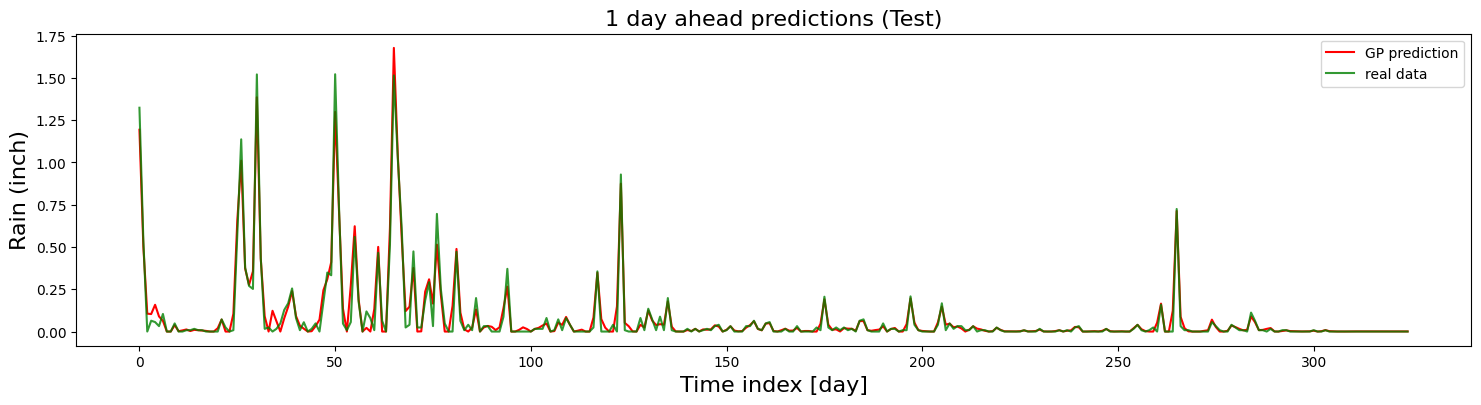

In [34]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(gtzero(gp_yp_test), 'r-',  alpha=1, label='GP prediction')
ax.plot(ys_test2, 'g-', alpha=0.8, label='real data')

## Filling 
# ax.fill_between(range(len(gp_yp_test)), gp_yp_test - 1.*np.sqrt(gp_yp_test_std), gp_yp_test + 1.*np.sqrt(gp_yp_test_std),
#                 color="r", alpha=0.2)

ax.legend()
# ax.set_xlim(0,len(gp_yp_test))
ax.set_ylabel("Rain (inch)", fontsize=16)
ax.set_xlabel("Time index [day]", fontsize=16)
ax.set_title("1 day ahead predictions (Test)", fontsize=16)

Text(0.5, 1.0, 'Changde')

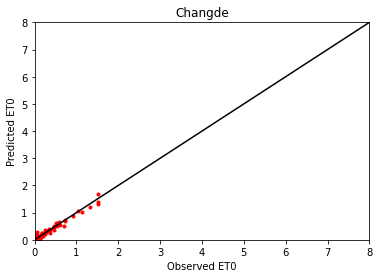

In [30]:
plt.plot(ys_test2, gp_yp_test, 'r.')

plt.plot([0, 8], [0, 8], 'k-')

plt.xlabel("Observed ET0")
plt.ylabel("Predicted ET0")

plt.xlim(0,8)
plt.ylim(0,8)
plt.title("Changde")

In [31]:
N = len(ys_test2)
metrics(ys_test2[:N-1], ys_test2[1:])

MAE: 0.09  RMSE: 0.22  R^2: -0.03
